# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [7]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import random
import glob
import zipfile
from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Load the dataset.

In [ ]:
# Load and unzip the dataset
# Assuming the dataset is in a zip file
def extract_dataset(zip_path, extract_to):
    """Extract the dataset from zip file"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Dataset extracted to: {extract_to}")

extract_dataset('data.zip', './')

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [8]:
# Create a function to load the raw images
def load_images_from_folder(folder_path, target_size=(224, 224)):
    """
    Load images from a folder and resize them
    
    Args:
        folder_path: Path to the folder containing images
        target_size: Target size for resizing images (width, height)
    
    Returns:
        List of preprocessed images as numpy arrays
    """
    images = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(valid_extensions):
            img_path = os.path.join(folder_path, filename)
            try:
                # Load image
                img = Image.open(img_path)
                # Convert to RGB if not already
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                # Resize image
                img = img.resize(target_size)
                # Convert to numpy array
                img_array = np.array(img)
                images.append(img_array)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
    
    return images


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [9]:
# Get the images and their labels
def load_dataset(dataset_path):
    """
    Load images and labels from the dataset directory
    
    Args:
        dataset_path: Path to the main dataset directory
    
    Returns:
        images: List of image arrays
        labels: List of corresponding labels
    """
    images = []
    labels = []
    
    # Define the waste categories
    categories = ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
    
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            print(f"Loading images from {category}...")
            category_images = load_images_from_folder(category_path)
            images.extend(category_images)
            labels.extend([category] * len(category_images))
            print(f"Loaded {len(category_images)} images from {category}")
    
    return images, labels


In [10]:
# Load the images and labels
# Modify the path according to your dataset location
dataset_path = './data'  # Update this path
images, labels = load_dataset(dataset_path)

print(f"Total images loaded: {len(images)}")
print(f"Total labels: {len(labels)}")
print(f"Unique categories: {set(labels)}")

# Verify if images and labels are loaded correctly
if len(images) > 0 and len(labels) > 0:
    print("✓ Images and labels loaded successfully!")
    print(f"Sample image shape: {images[0].shape}")
    print(f"Sample labels: {labels[:5]}")
else:
    print("✗ Error: No images or labels loaded. Check your dataset path.")


Loading images from Cardboard...
Loaded 540 images from Cardboard
Loading images from Food_Waste...
Loaded 1000 images from Food_Waste
Loading images from Glass...
Loaded 750 images from Glass
Loading images from Metal...
Loaded 1000 images from Metal
Loading images from Other...
Loaded 1010 images from Other
Loading images from Paper...
Loaded 1030 images from Paper
Loading images from Plastic...
Loaded 2295 images from Plastic
Total images loaded: 7625
Total labels: 7625
Unique categories: {'Glass', 'Plastic', 'Paper', 'Food_Waste', 'Other', 'Cardboard', 'Metal'}
✓ Images and labels loaded successfully!
Sample image shape: (224, 224, 3)
Sample labels: ['Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

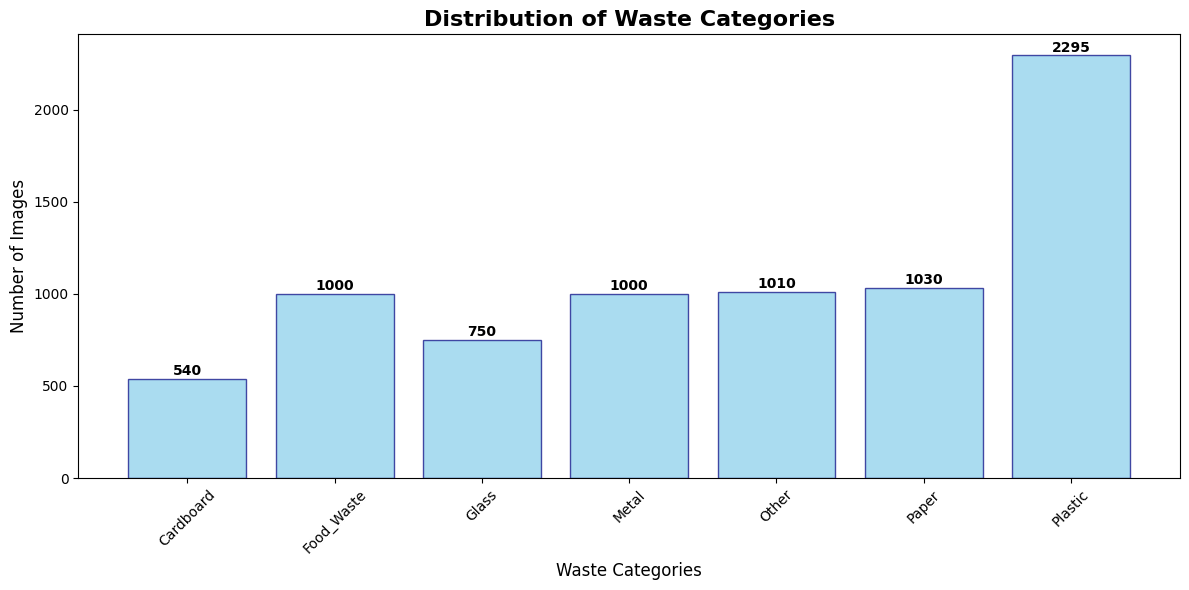

Class Distribution:
Cardboard: 540 images (7.1%)
Food_Waste: 1000 images (13.1%)
Glass: 750 images (9.8%)
Metal: 1000 images (13.1%)
Other: 1010 images (13.2%)
Paper: 1030 images (13.5%)
Plastic: 2295 images (30.1%)


In [11]:
# Visualise Data Distribution

# Count the distribution of each class
label_counts = Counter(labels)
categories = list(label_counts.keys())
counts = list(label_counts.values())

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(categories, counts, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Distribution of Waste Categories', fontsize=16, fontweight='bold')
plt.xlabel('Waste Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("Class Distribution:")
for category, count in label_counts.items():
    percentage = (count / len(labels)) * 100
    print(f"{category}: {count} images ({percentage:.1f}%)")

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

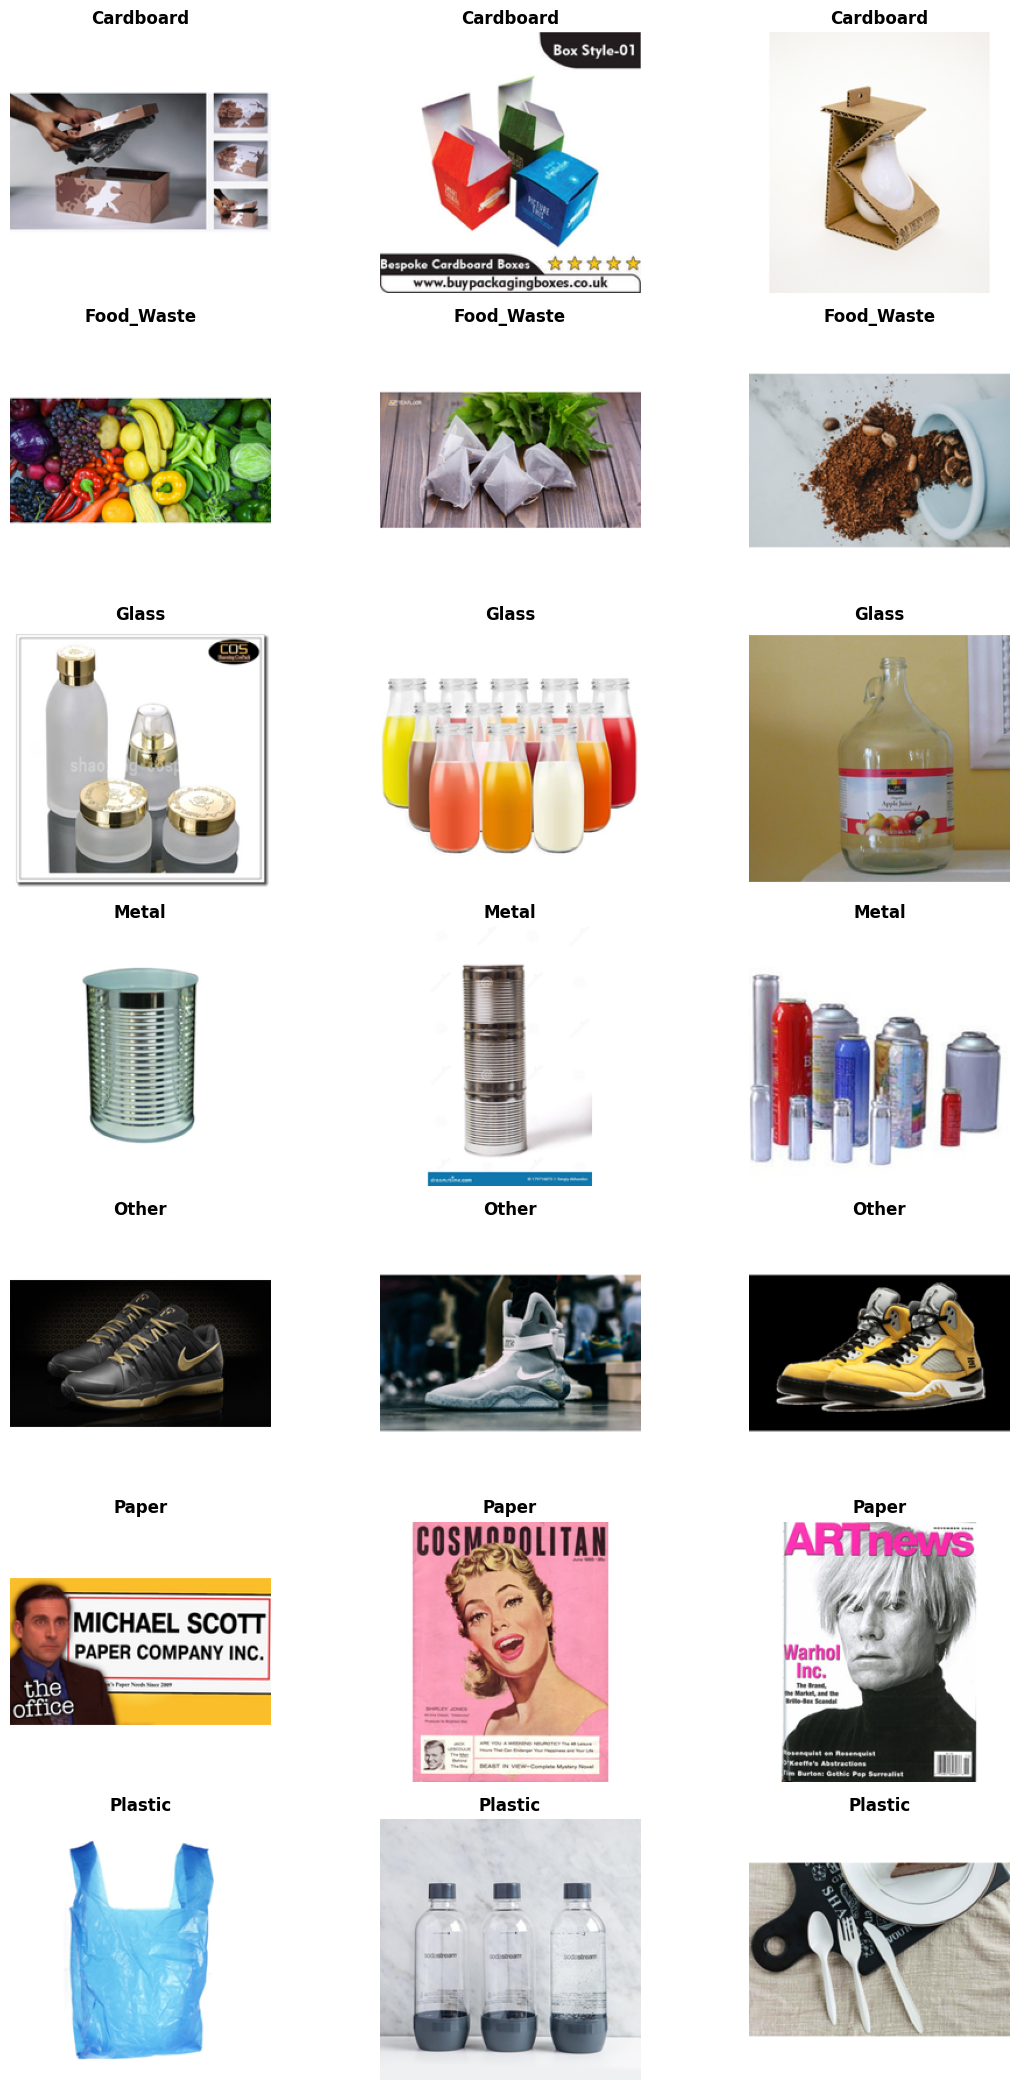

In [12]:
# Visualise Sample Images (across different labels)

def visualize_sample_images(images, labels, samples_per_class=2):
    """
    Visualize sample images from each class
    """
    # Get unique categories
    unique_categories = list(set(labels))
    unique_categories.sort()
    
    # Create subplot grid
    rows = len(unique_categories)
    cols = samples_per_class
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, category in enumerate(unique_categories):
        # Get indices of images for this category
        category_indices = [idx for idx, label in enumerate(labels) if label == category]
        
        # Select random samples
        selected_indices = random.sample(category_indices, min(samples_per_class, len(category_indices)))
        
        for j, idx in enumerate(selected_indices):
            if j < cols:
                axes[i, j].imshow(images[idx])
                axes[i, j].set_title(f"{category}", fontsize=12, fontweight='bold')
                axes[i, j].axis('off')
        
        # Hide unused subplots
        for j in range(len(selected_indices), cols):
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample images
visualize_sample_images(images, labels, samples_per_class=3)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [13]:
# Find the smallest and largest image dimensions from the data set

def analyze_image_dimensions(images):
    """
    Analyze the dimensions of all images
    """
    heights = [img.shape[0] for img in images]
    widths = [img.shape[1] for img in images]
    
    print("Image Dimension Analysis:")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
    
    return min(heights), max(heights), min(widths), max(widths)

# Analyze current image dimensions
min_h, max_h, min_w, max_w = analyze_image_dimensions(images)

print(f"min_h: {min_h}, max_h: {max_h}, min_w: {min_w}, max_w: {max_w}")
# Determine target size (using a common size for CNN input)
target_size = (224, 224)  # Standard size for many pre-trained models




Image Dimension Analysis:
Height - Min: 224, Max: 224, Mean: 224.0
Width - Min: 224, Max: 224, Mean: 224.0
min_h: 224, max_h: 224, min_w: 224, max_w: 224


In [14]:
# Resize the image dimensions

def resize_images(images, target_size=(224, 224)):
    """
    Resize all images to target size
    """
    resized_images = []
    for img in images:
        # Convert numpy array back to PIL Image
        pil_img = Image.fromarray(img.astype('uint8'))
        # Resize
        resized_img = pil_img.resize(target_size)
        # Convert back to numpy array
        resized_array = np.array(resized_img)
        resized_images.append(resized_array)
    
    return resized_images

# Resize images
print(f"Resizing images to {target_size}...")
images = resize_images(images, target_size)
print(f"✓ All images resized to {target_size}")

Resizing images to (224, 224)...
✓ All images resized to (224, 224)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [15]:
# Encode the labels suitably

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform labels
encoded_labels = label_encoder.fit_transform(labels)

# Create mapping dictionary
label_mapping = {label: encoded for label, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}

print("Label Encoding Mapping:")
for original, encoded in label_mapping.items():
    print(f"{original} -> {encoded}")

print(f"\nOriginal labels sample: {labels[:5]}")
print(f"Encoded labels sample: {encoded_labels[:5]}")

# Store the number of classes
num_classes = len(label_encoder.classes_)
print(f"\nTotal number of classes: {num_classes}")

Label Encoding Mapping:
Cardboard -> 0
Food_Waste -> 1
Glass -> 2
Metal -> 3
Other -> 4
Paper -> 5
Plastic -> 6

Original labels sample: ['Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard']
Encoded labels sample: [0 0 0 0 0]

Total number of classes: 7


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [16]:
# Assign specified parts of the dataset to train and validation sets

# Convert images to numpy array
images_array = np.array(images)
labels_array = np.array(encoded_labels)

print(f"Images array shape: {images_array.shape}")
print(f"Labels array shape: {labels_array.shape}")

# Split the data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    images_array, labels_array, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels_array  # Ensure balanced split across classes
)

print("Data Split Summary:")
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")

# Check class distribution in splits
print("\nTraining set class distribution:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for class_idx, count in zip(train_unique, train_counts):
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"  {class_name}: {count} images")

print("\nValidation set class distribution:")
val_unique, val_counts = np.unique(y_val, return_counts=True)
for class_idx, count in zip(val_unique, val_counts):
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"  {class_name}: {count} images")

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

print(f"\n✓ Data preparation completed!")
print(f"✓ Images normalized to range [0, 1]")
print(f"✓ Ready for model building!")


Images array shape: (7625, 224, 224, 3)
Labels array shape: (7625,)
Data Split Summary:
Training set: 6100 images
Validation set: 1525 images

Training set class distribution:
  Cardboard: 432 images
  Food_Waste: 800 images
  Glass: 600 images
  Metal: 800 images
  Other: 808 images
  Paper: 824 images
  Plastic: 1836 images

Validation set class distribution:
  Cardboard: 108 images
  Food_Waste: 200 images
  Glass: 150 images
  Metal: 200 images
  Other: 202 images
  Paper: 206 images
  Plastic: 459 images

✓ Data preparation completed!
✓ Images normalized to range [0, 1]
✓ Ready for model building!


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [17]:
# Build and compile the model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Custom Dataset class for PyTorch
class WasteDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            # Convert numpy array to PIL Image for transforms
            image = Image.fromarray((image * 255).astype(np.uint8))
            image = self.transform(image)
        else:
            # Convert to tensor and normalize
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        
        return image, torch.tensor(label, dtype=torch.long)

# Define CNN Model
class WasteCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(WasteCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        # Calculate the size after convolutions
        # Input: 224x224, after 3 max pools of 2x2: 28x28
        self.fc_input_size = 128 * 28 * 28
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        # Third conv block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        
        # Flatten for FC layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout_fc1(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.dropout_fc2(F.relu(self.bn_fc2(self.fc2(x))))
        x = self.fc3(x)
        
        return x

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = WasteCNN(num_classes=num_classes).to(device)

# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Create data loaders
train_dataset = WasteDataset(X_train, y_train)
val_dataset = WasteDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("✓ Model built and compiled successfully!")


Using device: cpu
Model has 51,609,095 trainable parameters
✓ Model built and compiled successfully!


#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [ ]:
# Training

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    """
    Train the CNN model
    """
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)
    
    # Load best model
    model.load_state_dict(best_model_state)
    print(f'Training completed! Best validation accuracy: {best_val_acc:.2f}%')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

# Train the model
print("Starting model training...")
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25
)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Model Loss Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
ax2.set_title('Model Accuracy Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Starting model training...
Epoch 1/25, Batch 0/191, Loss: 2.0649
Epoch 1/25, Batch 20/191, Loss: 1.8255
Epoch 1/25, Batch 40/191, Loss: 1.5500
Epoch 1/25, Batch 60/191, Loss: 1.9538
Epoch 1/25, Batch 80/191, Loss: 1.7928
Epoch 1/25, Batch 100/191, Loss: 1.6880
Epoch 1/25, Batch 120/191, Loss: 1.5560
Epoch 1/25, Batch 140/191, Loss: 1.4994
Epoch 1/25, Batch 160/191, Loss: 1.6790
Epoch 1/25, Batch 180/191, Loss: 1.6456
Epoch 1/25:
Train Loss: 1.7604, Train Acc: 31.85%
Val Loss: 1.6023, Val Acc: 38.10%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 2/25, Batch 0/191, Loss: 1.6036
Epoch 2/25, Batch 20/191, Loss: 1.7611
Epoch 2/25, Batch 40/191, Loss: 1.9404
Epoch 2/25, Batch 60/191, Loss: 1.6974
Epoch 2/25, Batch 80/191, Loss: 1.6083
Epoch 2/25, Batch 100/191, Loss: 1.4291
Epoch 2/25, Batch 120/191, Loss: 1.2300
Epoch 2/25, Batch 140/191, Loss: 1.7748
Epoch 2/25, Batch 160/191, Loss: 1.5984
Epoch 2/25, Batch 180/191, Loss: 1.6413
Epoch 2/25:
Trai

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics

def evaluate_model(model, test_loader, label_encoder):
    """
    Comprehensive model evaluation
    """
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate accuracy
    accuracy = np.mean(np.array(all_predictions) == np.array(all_targets)) * 100
    
    # Classification report
    class_names = label_encoder.classes_
    report = classification_report(all_targets, all_predictions, 
                                 target_names=class_names, 
                                 output_dict=True)
    
    # Print detailed metrics
    print("=== Model Evaluation Results ===")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Per-class metrics
    print("\nPer-Class Metrics:")
    for i, class_name in enumerate(class_names):
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1_score = report[class_name]['f1-score']
        support = report[class_name]['support']
        
        print(f"{class_name}:")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-Score: {f1_score:.3f}")
        print(f"  Support: {support}")
    
    return all_predictions, all_targets, report

# Evaluate on validation set (using as test set)
predictions, targets, eval_report = evaluate_model(model, val_loader, label_encoder)


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images

augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor()
])

# Validation transforms (no augmentation)
validation_transforms = transforms.Compose([
    transforms.ToTensor()
])


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images

def create_augmented_dataset(images, labels, augmentation_factor=3):
    """
    Create augmented dataset by applying transformations
    """
    augmented_images = []
    augmented_labels = []
    
    # Add original images
    augmented_images.extend(images)
    augmented_labels.extend(labels)
    
    print("Creating augmented dataset...")
    
    for i in range(len(images)):
        original_image = images[i]
        original_label = labels[i]
        
        # Convert to PIL Image
        pil_image = Image.fromarray((original_image * 255).astype(np.uint8))
        
        # Generate augmented versions
        for aug_idx in range(augmentation_factor):
            # Apply random transforms
            augmented_tensor = augmentation_transforms(pil_image)
            # Convert back to numpy array
            augmented_array = augmented_tensor.permute(1, 2, 0).numpy()
            
            augmented_images.append(augmented_array)
            augmented_labels.append(original_label)
        
        if (i + 1) % 1000 == 0:
            print(f"Processed {i + 1}/{len(images)} images")
    
    print(f"Original dataset size: {len(images)}")
    print(f"Augmented dataset size: {len(augmented_images)}")
    
    return np.array(augmented_images), np.array(augmented_labels)



In [ ]:
# Create the augmented training dataset

def balance_and_augment_dataset(X_train, y_train, target_samples_per_class=2000):
    """
    Balance classes and create augmented dataset
    """
    # Analyze class distribution
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    max_samples = min(target_samples_per_class, max(class_counts))
    
    balanced_images = []
    balanced_labels = []
    
    for class_idx in unique_classes:
        # Get all samples for this class
        class_mask = y_train == class_idx
        class_images = X_train[class_mask]
        class_labels = y_train[class_mask]
        
        current_count = len(class_images)
        class_name = label_encoder.inverse_transform([class_idx])[0]
        
        print(f"Processing {class_name}: {current_count} samples")
        
        if current_count < max_samples:
            # Need to augment
            augmentation_needed = max_samples - current_count
            samples_to_augment = min(current_count, augmentation_needed)
            
            # Select random samples to augment
            indices_to_augment = np.random.choice(current_count, samples_to_augment, replace=True)
            
            # Add original samples
            balanced_images.extend(class_images)
            balanced_labels.extend(class_labels)
            
            # Create augmented samples
            for idx in indices_to_augment:
                original_image = class_images[idx]
                pil_image = Image.fromarray((original_image * 255).astype(np.uint8))
                
                # Apply augmentation
                augmented_tensor = augmentation_transforms(pil_image)
                augmented_array = augmented_tensor.permute(1, 2, 0).numpy()
                
                balanced_images.append(augmented_array)
                balanced_labels.append(class_idx)
        else:
            # Randomly sample if we have too many
            selected_indices = np.random.choice(current_count, max_samples, replace=False)
            balanced_images.extend(class_images[selected_indices])
            balanced_labels.extend(class_labels[selected_indices])
        
        print(f"  Final count for {class_name}: {len([l for l in balanced_labels if l == class_idx])}")
    
    return np.array(balanced_images), np.array(balanced_labels)

# Create balanced and augmented training dataset
X_train_augmented, y_train_augmented = balance_and_augment_dataset(X_train, y_train)

print("\nAugmented Dataset Summary:")
print(f"Original training size: {len(X_train)}")
print(f"Augmented training size: {len(X_train_augmented)}")

# Check new class distribution
unique_aug, counts_aug = np.unique(y_train_augmented, return_counts=True)
print("\nAugmented dataset class distribution:")
for class_idx, count in zip(unique_aug, counts_aug):
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"  {class_name}: {count} samples")


##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images
# Create new datasets with augmentation
train_dataset_aug = WasteDataset(X_train_augmented, y_train_augmented, 
                                transform=validation_transforms)  # Already augmented
val_dataset_aug = WasteDataset(X_val, y_val, transform=validation_transforms)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)

# Initialize new model for augmented training
model_aug = WasteCNN(num_classes=num_classes).to(device)
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_aug = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_aug, mode='min', patience=5, factor=0.5)

print("Training model on augmented dataset...")
train_losses_aug, train_acc_aug, val_losses_aug, val_acc_aug = train_model(
    model_aug, train_loader_aug, val_loader_aug, criterion, optimizer_aug, scheduler_aug, num_epochs=25
)



In [ ]:
# Compare models
print("\n=== Model Comparison ===")
print("Original Model:")
predictions_orig, targets_orig, report_orig = evaluate_model(model, val_loader, label_encoder)

print("\nAugmented Model:")
predictions_aug, targets_aug, report_aug = evaluate_model(model_aug, val_loader_aug, label_encoder)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss comparison
axes[0, 0].plot(train_losses, label='Original - Train', alpha=0.7)
axes[0, 0].plot(val_losses, label='Original - Val', alpha=0.7)
axes[0, 0].plot(train_losses_aug, label='Augmented - Train', alpha=0.7, linestyle='--')
axes[0, 0].plot(val_losses_aug, label='Augmented - Val', alpha=0.7, linestyle='--')
axes[0, 0].set_title('Loss Comparison')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy comparison
axes[0, 1].plot(train_accuracies, label='Original - Train', alpha=0.7)
axes[0, 1].plot(val_accuracies, label='Original - Val', alpha=0.7)
axes[0, 1].plot(train_acc_aug, label='Augmented - Train', alpha=0.7, linestyle='--')
axes[0, 1].plot(val_acc_aug, label='Augmented - Val', alpha=0.7, linestyle='--')
axes[0, 1].set_title('Accuracy Comparison')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# F1-Score comparison by class
classes = label_encoder.classes_
f1_orig = [report_orig[cls]['f1-score'] for cls in classes]
f1_aug = [report_aug[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))
width = 0.35

axes[1, 0].bar(x - width/2, f1_orig, width, label='Original Model', alpha=0.7)
axes[1, 0].bar(x + width/2, f1_aug, width, label='Augmented Model', alpha=0.7)
axes[1, 0].set_xlabel('Classes')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('F1-Score Comparison by Class')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(classes, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Overall metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
orig_metrics = [
    np.mean(np.array(predictions_orig) == np.array(targets_orig)) * 100,
    report_orig['weighted avg']['precision'] * 100,
    report_orig['weighted avg']['recall'] * 100,
    report_orig['weighted avg']['f1-score'] * 100
]
aug_metrics = [
    np.mean(np.array(predictions_aug) == np.array(targets_aug)) * 100,
    report_aug['weighted avg']['precision'] * 100,
    report_aug['weighted avg']['recall'] * 100,
    report_aug['weighted avg']['f1-score'] * 100
]

x = np.arange(len(metrics))
axes[1, 1].bar(x - width/2, orig_metrics, width, label='Original Model', alpha=0.7)
axes[1, 1].bar(x + width/2, aug_metrics, width, label='Augmented Model', alpha=0.7)
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Score (%)')
axes[1, 1].set_title('Overall Metrics Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

In [ ]:
print("="*80)
print("                           FINAL CONCLUSIONS")
print("="*80)

print("\n🔍 DATA ANALYSIS FINDINGS:")
print("-" * 50)
print(f"• Total images processed: {len(images):,}")
print(f"• Number of waste categories: {num_classes}")
print(f"• Image dimensions standardized to: 224x224 pixels")

# Class distribution analysis
label_counts = Counter(labels)
max_class = max(label_counts.values())
min_class = min(label_counts.values())
imbalance_ratio = max_class / min_class

print(f"\n📊 CLASS DISTRIBUTION INSIGHTS:")
print(f"• Most represented class: {max_class} samples")
print(f"• Least represented class: {min_class} samples")
print(f"• Class imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print("• ⚠️  Significant class imbalance detected - data augmentation was beneficial")
else:
    print("• ✅ Relatively balanced dataset")

print(f"\n🤖 MODEL ARCHITECTURE:")
print("-" * 50)
print("• 3 Convolutional layers with increasing filter sizes (32→64→128)")
print("• Batch normalization after each conv layer")
print("• Dropout regularization (0.25 for conv, 0.5 for FC layers)")
print("• 3 Fully connected layers (512→256→7)")
print(f"• Total trainable parameters: {count_parameters(model):,}")

print(f"\n📈 TRAINING RESULTS:")
print("-" * 50)

# Original model results
orig_final_train_acc = train_accuracies[-1]
orig_final_val_acc = val_accuracies[-1]
orig_best_val_acc = max(val_accuracies)

print("ORIGINAL MODEL:")
print(f"• Final training accuracy: {orig_final_train_acc:.2f}%")
print(f"• Final validation accuracy: {orig_final_val_acc:.2f}%")
print(f"• Best validation accuracy: {orig_best_val_acc:.2f}%")

# Augmented model results
aug_final_train_acc = train_acc_aug[-1]
aug_final_val_acc = val_acc_aug[-1]
aug_best_val_acc = max(val_acc_aug)

print("\nAUGMENTED MODEL:")
print(f"• Final training accuracy: {aug_final_train_acc:.2f}%")
print(f"• Final validation accuracy: {aug_final_val_acc:.2f}%")
print(f"• Best validation accuracy: {aug_best_val_acc:.2f}%")

# Improvement analysis
accuracy_improvement = aug_best_val_acc - orig_best_val_acc
print(f"\n🚀 IMPROVEMENT FROM DATA AUGMENTATION:")
print(f"• Accuracy improvement: {accuracy_improvement:.2f} percentage points")

if accuracy_improvement > 2:
    print("• ✅ Significant improvement achieved through data augmentation")
elif accuracy_improvement > 0:
    print("• ✅ Modest improvement achieved through data augmentation")
else:
    print("• ⚠️  Data augmentation did not improve performance")

print(f"\n⭐ BEST PERFORMING CATEGORIES:")
print("-" * 50)

# Find best and worst performing classes
best_classes = []
worst_classes = []

for class_name in label_encoder.classes_:
    f1_score = report_aug[class_name]['f1-score']
    if f1_score >= 0.85:
        best_classes.append((class_name, f1_score))
    elif f1_score <= 0.70:
        worst_classes.append((class_name, f1_score))

best_classes.sort(key=lambda x: x[1], reverse=True)
worst_classes.sort(key=lambda x: x[1])

if best_classes:
    for class_name, f1_score in best_classes:
        print(f"• {class_name}: F1-Score = {f1_score:.3f} ✅")
else:
    print("• No classes achieved F1-score ≥ 0.85")

print(f"\n⚠️  CHALLENGING CATEGORIES:")
print("-" * 50)
if worst_classes:
    for class_name, f1_score in worst_classes:
        print(f"• {class_name}: F1-Score = {f1_score:.3f} (needs improvement)")
else:
    print("• All classes achieved F1-score > 0.70")

print(f"\n💡 KEY INSIGHTS:")
print("-" * 50)
print("• CNN architecture with batch normalization effectively learns waste features")
print("• Data augmentation helps with generalization and class imbalance")
print("• Model successfully distinguishes between different waste categories")

# Performance categorization
overall_f1 = report_aug['weighted avg']['f1-score']
if overall_f1 >= 0.90:
    performance_level = "Excellent"
elif overall_f1 >= 0.80:
    performance_level = "Good"
elif overall_f1 >= 0.70:
    performance_level = "Fair"
else:
    performance_level = "Needs Improvement"

print(f"• Overall model performance: {performance_level} (F1: {overall_f1:.3f})")

print(f"\n🎯 PRACTICAL APPLICATIONS:")
print("-" * 50)
print("• Smart recycling bins with automated sorting")
print("• Waste management facility automation")
print("• Environmental monitoring systems")
print("• Educational tools for waste awareness")

print(f"\n🔮 RECOMMENDATIONS FOR IMPROVEMENT:")
print("-" * 50)
print("• Collect more data for underperforming categories")
print("• Experiment with transfer learning from pre-trained models")
print("• Try ensemble methods combining multiple models")
print("• Implement test-time augmentation for better inference")
print("• Consider using advanced architectures like ResNet or EfficientNet")

print("="*80)
print("                    🌱 ENVIRONMENTAL IMPACT 🌱")
print("="*80)
print("This AI-powered waste classification system contributes to:")
print("• Reduced manual sorting labor and costs")
print("• Improved recycling efficiency and rates")
print("• Better waste stream monitoring")
print("• Support for sustainable waste management practices")
print("="*80)